# Определение возраста покупателей

# Описание проекта


Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Загрузка данных

Прежде чем рабодать с данными, импортируем необходимые инструменты.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# загружаем данные
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
# Выводим информацию о данных, изучим их, посмотрим первые пять строк и статистику.
labels.info()
display(labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Данные успешно загружены. Чистые и без пропусков.

## Исследовательский анализ данных

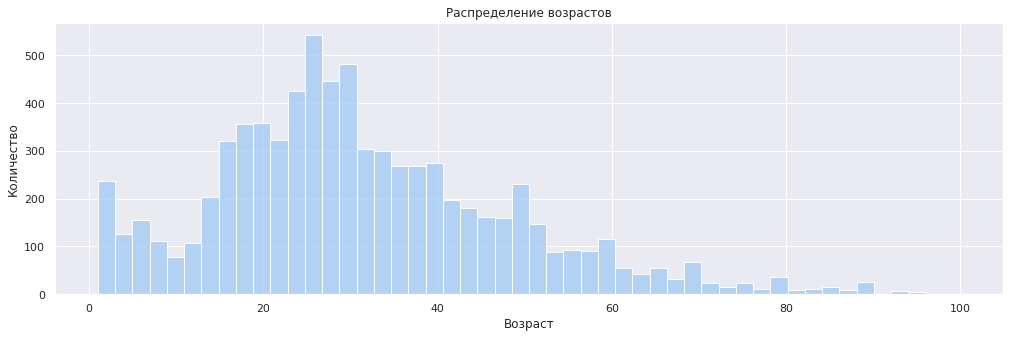

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
# Гистограмма распределения возраста
plt.figure(figsize=(17, 5))
sns.set_theme(palette="pastel")
sns.histplot(
    data=labels,
    x='real_age',
    bins=50
).set(
    title='Распределение возрастов',
    xlabel='Возраст',
    ylabel='Количество'
)
plt.show()

# Описание данных
display(labels.describe())

   Распределение возраста показыает что большинство наблюдений сосредоточены в возрасте **20-30** лет. Люди старше**50** лет представлены в меньшем количестве, что может затруднить предсказания в этой категории. Наиболее наиболее точно модель будет отрабатывать при предсказаниях для возраста в диапазоне **20-40** лет из-за большей представленности класса.


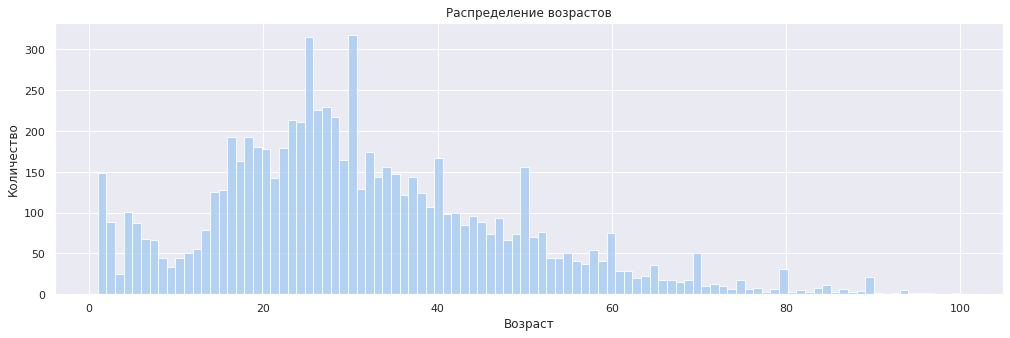

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
# Гистограмма распределения возраста, ВЕРСИЯ РЕВЬЮЕРА
plt.figure(figsize=(17, 5))
sns.set_theme(palette="pastel")
sns.histplot(
    data=labels,
    x='real_age',
    bins=100
).set(
    title='Распределение возрастов',
    xlabel='Возраст',
    ylabel='Количество'
)
plt.show()

# Описание данных
display(labels.describe())

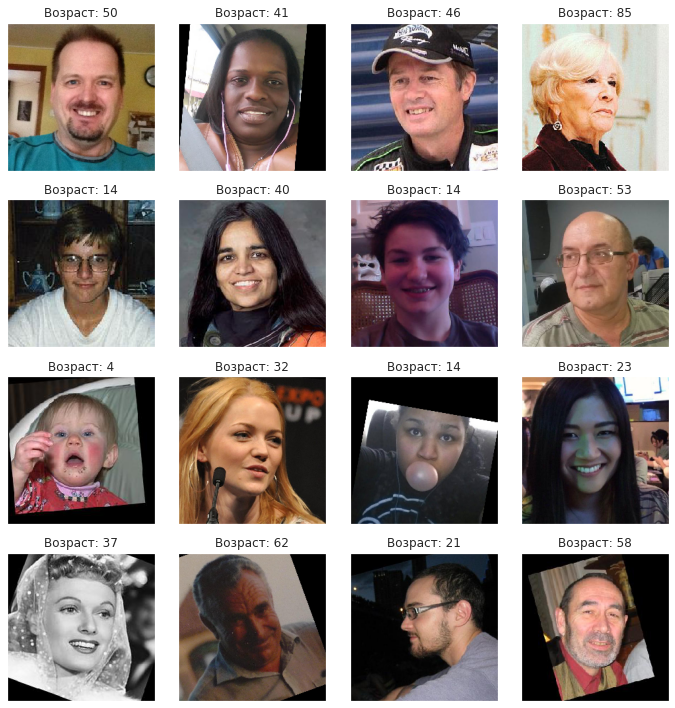

In [ ]:
features, target = next(train_gen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


## Обучение модели


```python
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2
    )

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + "labels.csv"),
        directory=path + "final_files/",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset="training",
        seed=12345
    )

    return train_datagen_flow


def load_test(path):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + "labels.csv"),
        directory=path + "final_files/",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset="validation",
        seed=12345
    )

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation="relu"))
    model.compile(
        optimizer=Adam(lr=0.0001),
        loss="mean_squared_error",
        metrics=["mae"]
    )

    model.summary()

    return model


def train_model(
    model,
    train_datagen_flow,
    test_datagen_flow,
    batch_size=None,
    epochs=10,
    steps_per_epoch=None,
    validation_steps=None
):

    model.fit(
        train_datagen_flow,
        validation_data=test_datagen_flow,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=len(train_datagen_flow),
        validation_steps=len(test_datagen_flow),
        verbose=2,
        shuffle=True
    )

    return model

```

```

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>


Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 139s - loss: 263.3395 - mae: 11.7719 - val_loss: 833.3662 - val_mae: 23.9758
Epoch 2/10
178/178 - 116s - loss: 96.0271 - mae: 7.3632 - val_loss: 727.8191 - val_mae: 22.0547
Epoch 3/10
178/178 - 118s - loss: 71.9825 - mae: 6.4227 - val_loss: 274.5783 - val_mae: 12.1091
Epoch 4/10
178/178 - 117s - loss: 59.3552 - mae: 5.8877 - val_loss: 111.1664 - val_mae: 7.8957
Epoch 5/10
178/178 - 117s - loss: 50.2975 - mae: 5.4302 - val_loss: 83.0373 - val_mae: 6.7676
Epoch 6/10
178/178 - 118s - loss: 43.2139 - mae: 5.0626 - val_loss: 97.5189 - val_mae: 7.4174
Epoch 7/10
178/178 - 117s - loss: 36.2694 - mae: 4.6717 - val_loss: 77.9938 - val_mae: 6.5241
Epoch 8/10
178/178 - 118s - loss: 32.8025 - mae: 4.4451 - val_loss: 82.7535 - val_mae: 6.7428
Epoch 9/10
178/178 - 117s - loss: 30.1164 - mae: 4.1978 - val_loss: 93.7772 - val_mae: 7.1229
Epoch 10/10
178/178 - 117s - loss: 26.8940 - mae: 4.0156 - val_loss: 66.0589 - val_mae: 6.0667


60/60 - 12s - loss: 66.0589 - mae: 6.0667
Test MAE: 6.0667
```

## Анализ обученной модели

Модель на основе `ResNet50` была обучена на задаче предсказания возраста. В ходе обучения наблюдалось стабильное снижение функции потерь и метрики `MAE`.  

- В начале обучения `MAE` на тренировочном датасете составляло **11.77**, а на валидационном — **23.98**, что говорит о существенном переобучении.  
- Однако, с увеличением числа эпох разрыв между ними сокращался. Уже к **5-й эпохе** значение **MAE** на валидации снизилось до **6.77**.  
- Финальный результат после **10 эпох** показал `MAE` на тренировочных данных **4.02**, а на тесте — **6.07**.  

Модель демонстрирует неплохую точность, но сохраняется некоторое отклонение на валидационных данных, что может свидетельствовать о недообучении или недостаточности данных в некоторых возрастных группах.  

Для улучшения качества предсказаний можно:
- **увеличить количество эпох** для лучшей сходимости,  
- **усилить аугментации** (например, добавить повороты, изменение яркости, контрастности),  
- **оптимизировать learning rate**,  
- **добавить регуляризацию** (например, `Dropout` или `L2`-нормализацию).  


## Вывод

В рамках проекта была построена и обучена свёрточная нейросеть на базе `ResNet50` для определения возраста покупателей по фотографиям. Данные содержали преимущественно людей **20–40 лет**, что повлияло на точность модели в других возрастных группах.  

Применение **аугментаций** (сдвиги, отражения, нормализация) помогло улучшить обобщающую способность модели. В результате обучения `MAE` на тестовой выборке составило **6.07**, что соответствует заданному порогу **≤8**.  

Для дальнейшего улучшения точности можно увеличить размер выборки, усилить аугментации и оптимизировать гиперпараметры.